In [4]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple, defaultdict

from robustness import logger
logger.setLevel('INFO')

from robustness import NETWORKS_DIR
from robustness.mpl_settings_v3 import *
from robustness.planar import create_proximity_graph
from robustness.auxiliary import (
    getLinearReg, 
    get_base_network_name, 
    powerlaw, 
    load_delta_data, 
    read_data_file
)
from robustness.plot_auxiliary import (
    letters,
    attack_dict,
    fig_dir, 
    load_delta,
    load_deltas,
    load_dataframe, 
    get_critical_measures,
    getPeaks,
    compute_fc_v2,
    get_rc_values,
    get_l_cutoff,
    load_comp_sizes_data
)

%matplotlib inline

net_type = 'DT'
param = 'param'

net_dir = os.path.join('..', 'networks', net_type)

marker_dict = {'num': 'o', 'Nsec': 's', 'varSgcc': '^', 'Sgcc': '*'}
color_dict = {'num': 'C0', 'Nsec': 'C1', 'varSgcc': 'C2', 'Sgcc': 'C3'}
linestyle_dict = {'num': '--', 'Nsec': '-.', 'varSgcc': ':', 'Sgcc': ':'}
measures_dict = {'num': r'$M_2$', 'Nsec': r'$S_2 L^2$', 'varSgcc': r'$\chi$', 'Sgcc': r'$N_1$'}
line_colors = {'num': 'k', 'Nsec': 'grey', 'varSgcc': 'brown', 'Sgcc': 'C8'}

In [2]:
#import matplotlib
#matplotlib.rcParams['mathtext.fontset'] = 'stix'

# **Main text**

## Figure 1

<ipython-input-78-253af9010348>:176: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


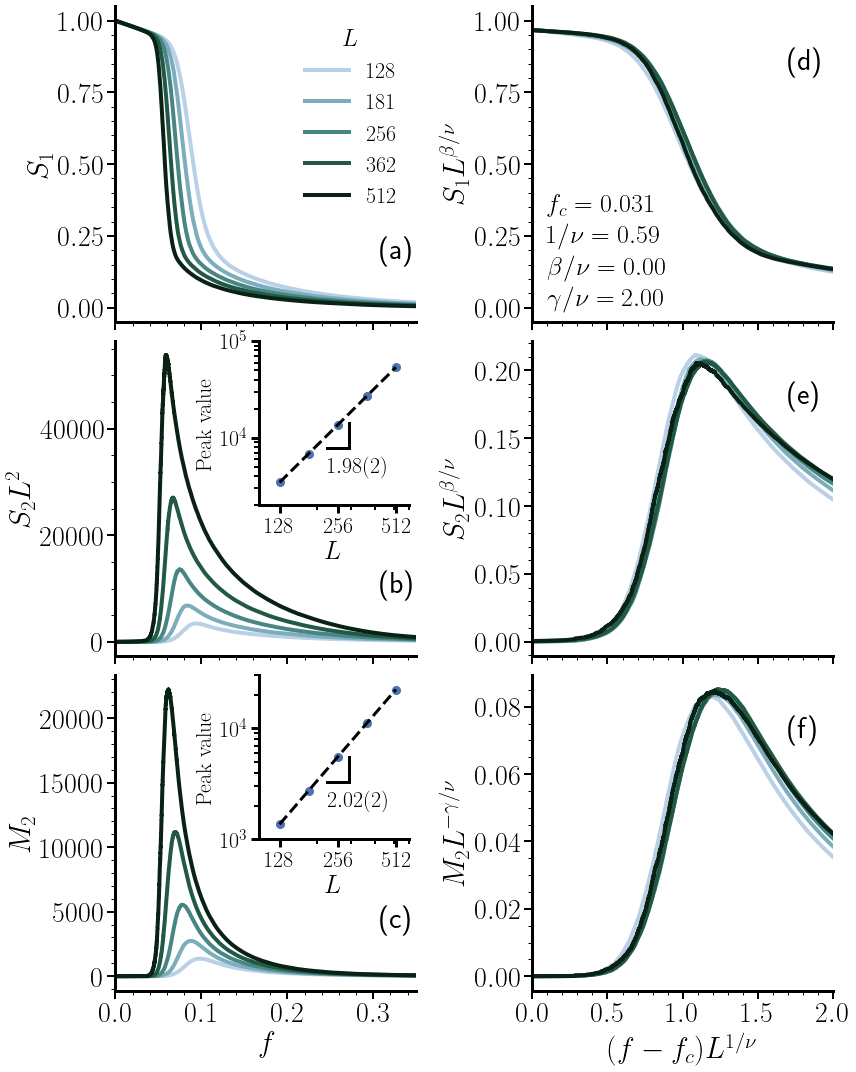

In [78]:
measures = ['num', 'Nsec']
attack = 'Btw'

sizes = [
    #8192, 
    16384, 32768, 65536, 131072,
    262144
]
data = {}

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
N_values = np.array(list(dfs.keys()))
L_values = np.sqrt(N_values)

for i, measure in enumerate(measures):
    measure_values = get_critical_measures(dfs, measure, fc='peak')
    Y_pred, slope, y_err = getLinearReg(L_values[-6:], measure_values[-6:])
    if measure == 'Nsec':
        beta_over_nu = 2 - slope
        delta_beta = y_err
    elif measure == 'num':
        gamma_over_nu = slope
        delta_gamma = y_err    
    data[measure] = [L_values, measure_values, Y_pred, slope, y_err]

    
sizes = [
    #8192, 
    16384, 32768, 65536, 131072,
    262144
]

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
N_values = np.array(list(dfs.keys()))
L_values = np.sqrt(N_values)

colormap = sns.cubehelix_palette(
    len(L_values), start=2, rot=0.3, light=0.8, dark=0.1
)
ncols = 2
nrows = 3
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
    
for ax in axes[:,0]:
    ax.set_xlim(0, 0.35)
    ax.set_xticks([0.0, 0.1, 0.2, 0.3])
    ax.set_xlabel(r'$f$')
for ax in axes[:,1]:
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 0.5, 1, 1.5, 2])
    ax.set_xlabel(r'$(f-f_c) L^{1/\nu}$')

for ax in axes[:2,:].flatten():
    ax.set_xticklabels([])
    ax.set_xlabel('')
        
ax = axes[0,0]
ax.set_ylabel(r'$S_1$')
ax = axes[2,0]
ax.set_ylabel(r'$M_2$')
ax = axes[1,0]
#ax.set_ylim(-500, 17000)
#ax.set_ylim(-500, 32000)
ax.set_ylabel(r'$S_2L^2$')
    
for i in [1]:
    ax = axes[0,i]
    ax.set_ylabel(r'$S_1 L^{\beta/\nu}$')
    ax = axes[2,i]
    ax.set_ylabel(r'$M_2 L^{-\gamma/\nu}$')
    ax = axes[1,i]
    ax.set_ylabel(r'$S_2 L^{\beta/\nu}$')
        
axes[0,0].text(0.88, 0.2, '(a)', transform=axes[0,0].transAxes, fontsize=30, weight='bold')
axes[1,0].text(0.88, 0.2, '(b)', transform=axes[1,0].transAxes, fontsize=30, weight='bold')
axes[2,0].text(0.88, 0.2, '(c)', transform=axes[2,0].transAxes, fontsize=30, weight='bold')
axes[0,1].text(0.85, 0.8, '(d)', transform=axes[0,1].transAxes, fontsize=30, weight='bold')
axes[1,1].text(0.85, 0.8, '(e)', transform=axes[1,1].transAxes, fontsize=30, weight='bold')
axes[2,1].text(0.85, 0.8, '(f)', transform=axes[2,1].transAxes, fontsize=30, weight='bold')


one_over_nu = 0.59
gamma_over_nu = 2.0
beta_over_nu = 0
fc = 0.031
ax  = axes[0,1]
ax.text(0.05, 0.35, r'$f_c = {{{:.3f}}}$'.format(fc), transform=ax.transAxes, fontsize=26)
ax.text(0.05, 0.25, r'$1/\nu = {{{:.2f}}}$'.format(one_over_nu), transform=ax.transAxes, fontsize=26)
ax.text(0.05, 0.15, r'$\beta/\nu = {{{:.2f}}}$'.format(beta_over_nu), transform=ax.transAxes, fontsize=26)
ax.text(0.05, 0.05, r'$\gamma/\nu = {{{:.2f}}}$'.format(gamma_over_nu), transform=ax.transAxes, fontsize=26)

linewidth = 4
for i, (N, df) in enumerate(dfs.items()):
    L = np.sqrt(N)
    axes[0,0].plot(
        df.f, df.Sgcc, linestyle='-', color=colormap[i],
        label=r'${{{}}}$'.format(int(L)), linewidth=linewidth
    )
    axes[1,0].plot(df.f, df.Nsec, linestyle='-', color=colormap[i], linewidth=linewidth)
    axes[2,0].plot(df.f, df.num/N, linestyle='-', color=colormap[i], linewidth=linewidth)        
        
for i, (N, df) in enumerate(dfs.items()):
    L = np.sqrt(N)

    axes[0,1].plot(
        (df.f-fc)*L**one_over_nu, df.Sgcc*N**(beta_over_nu), 
        linestyle='-', color=colormap[i], linewidth=linewidth
    )
    axes[1,1].plot(
        (df.f-fc)*L**one_over_nu, df.Nsec*L**(beta_over_nu-2), 
        linestyle='-', color=colormap[i], linewidth=linewidth
    )
    axes[2,1].plot(
        (df.f-fc)*L**one_over_nu, df.num*L**(-gamma_over_nu)/N, 
        linestyle='-', color=colormap[i], linewidth=linewidth
    )          

legend = axes[0,0].legend(loc='upper right', fontsize=22, frameon=False)
legend.set_title(r'$L$', prop={'size':24})

## Insets
measures = ['Nsec', 'num']
    
bbox_to_anchor = (.52, .52, .5, .52)
axinses = []
for i in range(len(measures)):
    axins = inset_axes(
        axes[i+1,0], width="100%", height="100%",
        bbox_to_anchor=bbox_to_anchor,
        bbox_transform=axes[i+1,0].transAxes
    )
    axinses.append(axins)

axinses[0].set_ylim(2e3, 1e5)
axinses[1].set_ylim(1e3, 3e4)
for ax in axinses:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(100, 600)
    ax.set_xticks([128, 256, 512])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$', fontsize=26)
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.set_ylabel(r'$\mathrm{Peak\;values}$', fontsize=24)

for i, measure in enumerate(measures):
    ax = axinses[i]
    ax.set_ylabel(r'$\mathrm{Peak\;value}$', fontsize=22)
    L_values, measure_values, Y_pred, slope, y_err = data[measure]
    markers1, = ax.plot(L_values, measure_values, 'o', markersize=8)
    c = measure_values[-3] / L_values[-3]**slope
    label = r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err*1.1)
    ax.plot(L_values, powerlaw(L_values, slope, c), '--', color='k')
    ax.plot([0.45, 0.6], [0.35, 0.35], '-', color='k', transform=ax.transAxes)
    ax.plot([0.6, 0.6], [0.35, 0.5], '-', color='k', transform=ax.transAxes)
    ax.text(0.45, 0.20, label, transform=ax.transAxes, fontsize=22)

for ax in axes.flatten():
    ax.tick_params(which='major', width=2, length=8)
    ax.tick_params(which='minor', width=1, length=4)
    
sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'collapse_B_twoCols_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

## Figure 2

In [2]:
def get_histo(comp_sizes, nbins=None, log=True, density=True):
    
    if nbins is None:
        nbins = 20
    
    mask = comp_sizes > 0
    comp_sizes = comp_sizes[mask]     
    min_s = np.min(comp_sizes)
    max_s = np.max(comp_sizes)
    if log:
        bins = np.logspace(np.log10(min_s), np.log10(max_s), nbins)
    else:
        bins = np.linspace(min_s, max_s+1, nbins)
    freq, bin_edges = np.histogram(comp_sizes, bins=bins, density=density)
    freq_norm = freq.astype('float')
    freq_norm[freq_norm==0] = np.NaN
    
    freq_norm = freq_norm / np.diff(bin_edges)
    
    mask = ~np.isnan(freq_norm)
    X = bins[:-1]
    X = X[mask]
    Y = freq_norm[mask]

    return X, Y

attack = 'Btw'
sizes = [
    #8192, 
    16384, 32768, 65536, 131072, 262144
]
#sizes = [65536]
dropLargest = 0

f_values_dict = {
    262144: ['0.05481', '-', '-'],
    131072: ['0.06100', '0.06737', '0.06874'],
    65536: ['0.06786', '0.07231', '0.07579'],
    32768: ['0.07524', '0.08041', '0.08307'],
    16384: ['0.08338', '0.09088', '0.09326'],
    8192: ['0.09316', '0.10266', '0.10789']
}

all_comp_sizes = {}
nseeds_values = {}

for size in sizes:
    print(size)
    f_value = f_values_dict[size][0]
    comp_sizes, nseeds = load_comp_sizes_data(net_type, param, size, attack, f_value, dropLargest)
    nseeds_values[size] = nseeds
    all_comp_sizes[size] = comp_sizes

print(nseeds_values)

16384
32768
65536
131072
262144
{16384: 1000, 32768: 1000, 65536: 10000, 131072: 9958, 262144: 1662}


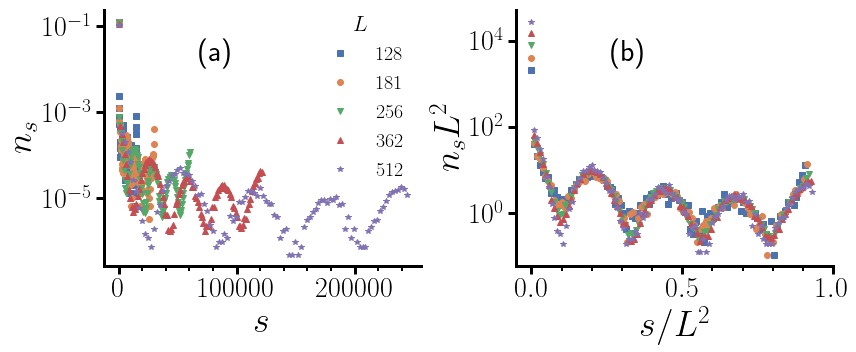

In [3]:
ncols = 2
fig, axes = plt.subplots(figsize=(6*ncols,5), ncols=ncols)

ax = axes[0]
ax.text(0.3, 0.8, '(a)', transform=ax.transAxes, fontsize=30, weight='bold')
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)

#ax.set_xscale('log')
#ax.set_xlim(-0.05, 1)
#ax.set_ylim(1e3, 1e6)
ax.set_yscale('log')
ax.set_xlabel(r'$s$', fontsize=36)
ax.set_ylabel(r'$n_s$', fontsize=36)    

for i, N in enumerate(sizes):

    comp_sizes = all_comp_sizes[N]
    comp_sizes = comp_sizes[comp_sizes>0]
    nbins = 100   
    X, Y = get_histo(comp_sizes, nbins=nbins, log=False, density=False)
    Y = Y / nseeds_values[N]    
    #Y = Y / (nseeds_values[N] * (X[1]-X[0]))
    
    ax.plot(
        X, Y, marker=markers[i], linestyle='', label=r'${{{}}}$'.format(int(np.sqrt(N)))
    ) 
legend = ax.legend(loc='upper right', bbox_to_anchor=(1, 1.05), fontsize=20, frameon=False)
legend.set_title(r'$L$', prop={'size':22})


ax = axes[1]
ax.text(0.3, 0.8, '(b)', transform=ax.transAxes, fontsize=30, weight='bold')
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)

ax.set_xlim(-0.05, 1)
ax.set_yscale('log')
ax.set_xlabel(r'$s/L^2$', fontsize=36)
ax.set_ylabel(r'$n_s L^2$', fontsize=36)    

for i, N in enumerate(sizes):

    comp_sizes = all_comp_sizes[N]
    comp_sizes = comp_sizes[comp_sizes>0]
    nbins = 100   
    X, Y = get_histo(comp_sizes, nbins=nbins, log=False, density=False)
    #Y = Y / (nseeds_values[N] * (X[1]-X[0]))
    Y = Y / nseeds_values[N] 
    
    X = X / N
    Y = Y * N 
    
    ax.plot(
        X, Y, marker=markers[i], linestyle=''#, label=r'${{{}}}$'.format(N)
    ) 

plt.tight_layout()
base_name = 'ns_scaled_B_gcc_linear_{}'.format(net_type) 
sns.despine()
fig_name = os.path.join(fig_dir, base_name)
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

<ipython-input-50-8cd8acffa329>:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


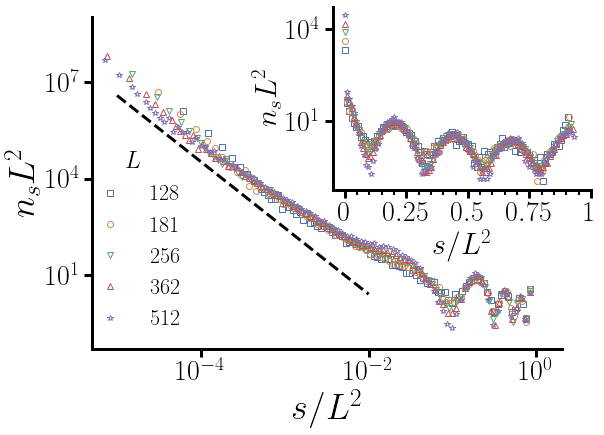

In [50]:
ncols = 1
fig, ax = plt.subplots(figsize=(8*ncols,6))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(5e-6, 2)
ax.set_ylim(0.05, 1e9)
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$s/L^2$', fontsize=36)
ax.set_ylabel(r'$n_s L^2$', fontsize=36)    

for i, N in enumerate(sizes):

    comp_sizes = all_comp_sizes[N]
    comp_sizes = comp_sizes[comp_sizes>0]
    nbins = 100   
    X, Y = get_histo(comp_sizes, nbins=nbins, log=True, density=False)
    X = X / N
    Y = Y * N / nseeds_values[N]
    #Y = Y / (nseeds_values[N] * (X[1]-X[0]))
    
    ax.plot(
        X, Y, marker=markers[i], linestyle='', fillstyle='none',
        label=r'${{{}}}$'.format(int(np.sqrt(N)))
    ) 
legend = ax.legend(loc='lower left', bbox_to_anchor=(-0.05, 0.0), fontsize=22, frameon=False)
legend.set_title(r'$L$', prop={'size':24})

X = np.logspace(-5, -2)
Y = powerlaw(X, -2.055, 2e-4)
ax.plot(X, Y, linestyle='--', color='k')

######################################################


bbox_to_anchor = (.54, .52, .55, .55)
axins = inset_axes(
    ax, width="100%", height="100%",
    bbox_to_anchor=bbox_to_anchor,
    bbox_transform=ax.transAxes
)
axins.tick_params(which='minor', length=5)
axins.tick_params(which='major', length=8)
axins.set_xlim(-0.05, 1)
axins.set_xticks([0, 0.25, 0.5, 0.75, 1])
axins.set_xticklabels([r'$0$', r'$0.25$',r'$0.5$', r'$0.75$', r'$1$'])
axins.set_yscale('log')
axins.set_xlabel(r'$s/L^2$', fontsize=30)
axins.set_ylabel(r'$n_s L^2$', fontsize=30)    

for i, N in enumerate(sizes):

    comp_sizes = all_comp_sizes[N]
    comp_sizes = comp_sizes[comp_sizes>0]
    nbins = 100   
    X, Y = get_histo(comp_sizes, nbins=nbins, log=False, density=False)
    Y = Y / nseeds_values[N] 
    
    X = X / N
    Y = Y * N 
    
    axins.plot(
        X, Y, marker=markers[i], linestyle='', fillstyle='none'
    ) 


plt.tight_layout()
base_name = 'ns_scaled_B_gcc_linear_{}'.format(net_type) 
sns.despine()
fig_name = os.path.join(fig_dir, base_name)
plt.savefig(fig_name + '.png', transparent=False)
plt.savefig(fig_name + '.pdf')
plt.show()

## Figure 3

In [81]:
attack = 'Btw'

sizes = np.array([
    256, 512, 
    1024, 2048, 4096, 
    8192, 16384, 32768, 65536,131072, 262144
])
all_mean_values = []
lower_mean_values = []
upper_mean_values = []
lower_std_values = []
upper_std_values = []
all_std_values = []
nseeds_values = []
fluctuations = {}
datas = {}
for i, N in enumerate(sizes):
    try:
        delta_data, nseeds = load_delta(
            net_type, N, param, attack, min_nseeds=10, return_nseeds=True
    )
    except FileNotFoundError:
        print(N)
        raise
    datas[N] = np.array(delta_data)
    nseeds_values.append(nseeds)
    
    delta_data[:,2] = delta_data[:,2]*N
    df = pd.DataFrame(delta_data, columns=['rc', 'delta', 'N1'])
    
    mean_values = df.mean().values
    std_values = df.std().values
    
    th = 0.35
    lower_mean_values.append(df[df.delta<=th].mean().values)
    upper_mean_values.append(df[df.delta>th].mean().values)
    
    lower_std_values.append(df[df.delta<=th].std().values)
    upper_std_values.append(df[df.delta>th].std().values)
    
    all_mean_values.append(mean_values)
    all_std_values.append(std_values)
    
    
all_mean_values = np.array(all_mean_values)
lower_mean_values = np.array(lower_mean_values)
upper_mean_values = np.array(upper_mean_values)
lower_std_values = np.array(lower_std_values)
upper_std_values = np.array(upper_std_values)
all_std_values = np.array(all_std_values)
nseeds_values = np.array(nseeds_values)

rc_values = all_mean_values[:,0]
delta_values = all_mean_values[:,1]

print(sizes, rc_values, delta_values)

mean_values = {
    'all': all_mean_values[:,1],
    'lower': lower_mean_values[:,1],
    'upper': upper_mean_values[:,1]
}

std_values = {
    'all': all_std_values[:,1],
    'lower': lower_std_values[:,1],    
    'upper': upper_std_values[:,1]
}

labels = {
    'lower': r'$\mathrm{Left\;peak}$',
    'all': r'$\mathrm{All}$',
    'upper': r'$\mathrm{Right\;peak}$',
}


[   256    512   1024   2048   4096   8192  16384  32768  65536 131072
 262144] [0.2260082  0.1839127  0.14868398 0.12307358 0.10567444 0.09316479
 0.08339266 0.07524434 0.06786433 0.06100343 0.05480698] [0.25604492 0.26970781 0.28197881 0.29040273 0.29311506 0.29372362
 0.29129794 0.2877203  0.2850116  0.28123697 0.27803269]


In [84]:
def fig_3a(ax, datas):
    ax.text(0.9, 0.9, '(a)', transform=ax.transAxes, fontsize=30, weight='bold')
    ax.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5])
    ax.set_xlim(0.05, 0.5)
    ax.set_ylabel(r'$p(\Delta^{(i)})$')
    ax.set_xlabel(r'$\Delta^{(i)}$')

    for i, (N, data) in enumerate(datas.items()):
        _data = data[:,1] 
        freq, bin_edges = np.histogram(_data, bins=30, density=True)
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        label = r'${{{}}}$'.format(int(np.sqrt(N)))
        ax.plot(bin_centers, freq, markers[i], color=colormap[i], label=label)

    ax.axvline(0.34, color='k', linestyle=':')
    legend = ax.legend(
        fontsize=20, frameon=False,
        loc='upper left',
        bbox_to_anchor=(-0.05, 1.05)
    )
    legend.set_title(r'$L$', prop={'size':22})

def fig_3b(ax, datas):
    #ax.text(0.04, 0.88, '(b)', transform=ax.transAxes, fontsize=30, weight='bold')
    ax.text(0.9, 0.9, '(b)', transform=ax.transAxes, fontsize=30, weight='bold')
    ax.set_xlim(0.03, 0.18)
    ax.set_xticks([0.05, 0.1, 0.15])
    ax.set_ylabel(r'$p(f_{\Delta}^{(i)})$')
    ax.set_xlabel(r'$f_{\Delta}^{(i)}$')

    for i, (N, data) in enumerate(datas.items()):
        _data = data[:,0]
        freq, bin_edges = np.histogram(_data, bins=30, density=True)
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        ax.plot(
            bin_centers, freq, 
            markers[i], 
            color=colormap[i]
        )

    bbox_to_anchor = (.54, .52, .5, .52)
    axins = inset_axes(
        ax, width="100%", height="100%",
        bbox_to_anchor=bbox_to_anchor,
        bbox_transform=ax.transAxes
    )
    axins.patch.set_alpha(0)
    axins.set_ylabel(r'$p(\phi_{\Delta}^{(i)})$')
    axins.set_xlabel(r'$\phi_{\Delta}^{(i)}$')
    axins.set_xlim(-1.1, 1.1)

    def gaussian(X, mu, sigma, c=1):
        return (c/np.sqrt(2*np.pi)*sigma)*np.exp(-0.5*((X-mu)/sigma)**2)

    for i, (N, data) in enumerate(datas.items()):
        L = np.sqrt(N)
        _data = (data[:,0]-data[:,0].mean())*L**(0.6)
        freq, bin_edges = np.histogram(_data, bins=50, density=True)
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        X = bin_centers
        Y = freq
        axins.plot(X, Y, markers[i], color=colormap[i])
        mu, sigma, c = 0, 0.2, 25
        axins.plot(X, gaussian(X, mu, sigma, c), linestyle='-', color='C8')


def fig_3c(ax):
    attack = 'Btw'
    X = np.sqrt(sizes)
    ax.text(0.9, 0.9, '(c)', transform=ax.transAxes, fontsize=30, weight='bold')
    ax.set_xscale('log')
    ax.set_ylim(0.18, 0.56)
    ax.set_xlim(26, 600)
    ax.set_xticks([32, 64, 128, 256, 512])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    ax.set_ylabel(r'$\Delta$')

    for i, (kind, Y) in enumerate(mean_values.items()):
        ax.plot(X, Y, markers[i], markersize=10, label=labels[kind])
    ax.legend(loc=(0.05, 0.67), fontsize=20)

def fig_3d(ax):
    attack = 'Btw'
    X = np.sqrt(sizes)
    ax.text(0.04, 0.9, '(d)', transform=ax.transAxes, fontsize=30, weight='bold')
    ax.set_xscale('log')
    ax.set_xlim(26, 600)
    ax.set_xticks([32, 64, 128, 256, 512])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    ax.set_ylabel(r'$\chi_{\Delta}$')

    for i, (kind, Y) in enumerate(std_values.items()):

        ax.plot(X, Y, markers[i], markersize=10, label=labels[kind])

        if i == 1:
            Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
            c = Y[-1] / X[-1]**slope
            label2 = label=r'${{{:.2f}}}({{{:.0f}}})$'.format(-slope, 100*y_err)

def fig_3e(ax):
    attack = 'Btw'
    X = np.sqrt(sizes)
    ax.text(0.9, 0.9, '(e)', transform=ax.transAxes, fontsize=30, weight='bold')
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)

    ax.set_xscale('log')
    ax.set_xlabel(r'$L$')
    ax.set_xlim(25, 650)
    xticks = [32, 64, 128, 256, 512]
    ax.set_xticks(xticks)
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

    ax.set_yscale('log')
    ax.set_ylabel(r'$f_{\Delta}\mathrm{\; and\;} \chi_{f_{\Delta}}$')

    Y = all_mean_values[:,0]# / sizes
    Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
    c = Y[-3] / X[-3]**slope
    ax.plot(X, Y, markers[3], color='C3', markersize=10, label=r'$f_{\Delta}$')
    label1 = label=r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
    ax.plot(
        X, powerlaw(X, slope, c), '--', color='k', 
        label=label1, zorder=-1
    )

    Y = all_std_values[:,0]#/ sizes
    Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
    c = Y[-3] / X[-3]**slope
    ax.plot(X, Y, markers[4], color='C4', markersize=10, label=r'$\chi_{f_{\Delta}}$')

    label2 = label=r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
    ax.plot(
        X, powerlaw(X, slope, c), '-.', color='gray', 
        label=label2, zorder=-1
    )
    ax.legend(fontsize=22, loc=(0.05, 0.9), frameon=False)

    ax.plot([0.45, 0.65], [0.78, 0.78], '-', color='k', transform=ax.transAxes)
    ax.plot([0.65, 0.65], [0.78, 0.71], '-', color='k', transform=ax.transAxes)
    ax.text(0.43, 0.82, label1, transform=ax.transAxes, fontsize=22)

    ax.plot([0.3, 0.5], [0.37, 0.37], '-', color='k', transform=ax.transAxes)
    ax.plot([0.5, 0.5], [0.37, 0.27], '-', color='k', transform=ax.transAxes)
    ax.text(0.29, 0.4, label2, transform=ax.transAxes, fontsize=22)

    handles, labels = ax.get_legend_handles_labels()
    ## Markers
    order = [0, 2]
    legend1 = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
              fontsize=22, loc=(0.64, 0.22))

def fig_3f(ax):
    ax.text(0.04, 0.9, '(f)', transform=ax.transAxes, fontsize=30, weight='bold')
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)

    ax.set_xscale('log')
    ax.set_xlabel(r'$L$')
    ax.set_xlim(25, 650)
    xticks = [32, 64, 128, 256, 512]
    ax.set_xticks(xticks)
    ax.set_yticks([1e2, 1e3, 1e4, 1e5])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

    ax.set_yscale('log')
    ax.set_ylabel(r'$N_{1,{\Delta}}\mathrm{\; and\;} \chi_{N_{1,\Delta}}$')

    Y = all_mean_values[:,2]
    Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
    c = Y[-3] / X[-3]**slope
    ax.plot(X, Y, markers[3], color='C3', markersize=10, label=r'$N_{1,{\Delta}}$')
    label1 = label=r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
    ax.plot(
        X, powerlaw(X, slope, c), '--', color='k', 
        label=label1, zorder=-1
    )

    Y = all_std_values[:,2]#/ sizes
    Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
    c = Y[-3] / X[-3]**slope
    ax.plot(X, Y, markers[4], color='C4', markersize=10, label=r'$\chi_{N_{1,\Delta}}$')

    label2 = label=r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
    ax.plot(
        X, powerlaw(X, slope, c), '-.', color='gray', 
        label=label2, zorder=-1
    )
    ax.legend(fontsize=22, loc=(0.05, 0.9), frameon=False)

    ax.plot([0.25, 0.43], [0.68, 0.68], '-', color='k', transform=ax.transAxes)
    ax.plot([0.25, 0.25], [0.68, 0.53], '-', color='k', transform=ax.transAxes)
    ax.text(0.24, 0.71, label1, transform=ax.transAxes, fontsize=22)

    ax.plot([0.65, 0.8], [0.55, 0.55], '-', color='k', transform=ax.transAxes)
    ax.plot([0.8, 0.8], [0.55, 0.7], '-', color='k', transform=ax.transAxes)
    ax.text(0.65, 0.45, label2, transform=ax.transAxes, fontsize=22)

    handles, labels = ax.get_legend_handles_labels()
    ## Markers
    order = [0, 2]
    legend1 = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
              fontsize=22, loc=(0.6, 0.05))

<ipython-input-85-e7f4453dedea>:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


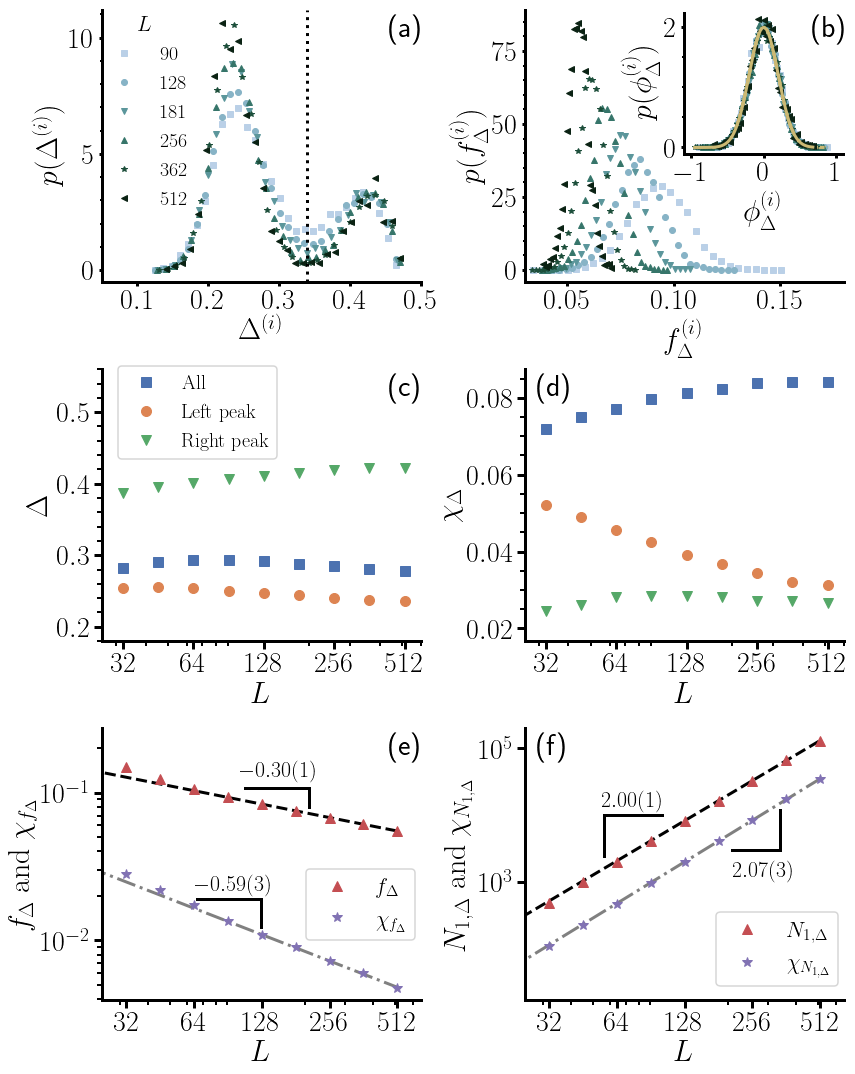

In [85]:
attack = 'Btw'
X = np.sqrt(sizes)

_datas = {
    N: datas[N] for N in datas.keys() 
    if int(np.sqrt(N)) in [90, 128, 181, 256, 362, 512]
}

colormap = sns.cubehelix_palette(
    len(_datas), start=2, rot=0.3, light=0.8, dark=0.1
)
ncols = 2
nrows = 3
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

fig_3a(axes[0,0], _datas)
fig_3b(axes[0,1], _datas)
fig_3c(axes[1,0])
fig_3d(axes[1,1])
fig_3e(axes[2,0])
fig_3f(axes[2,1])

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'gap_exp_scaling_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

# Figura 4

start plot
Plot components
start scatter


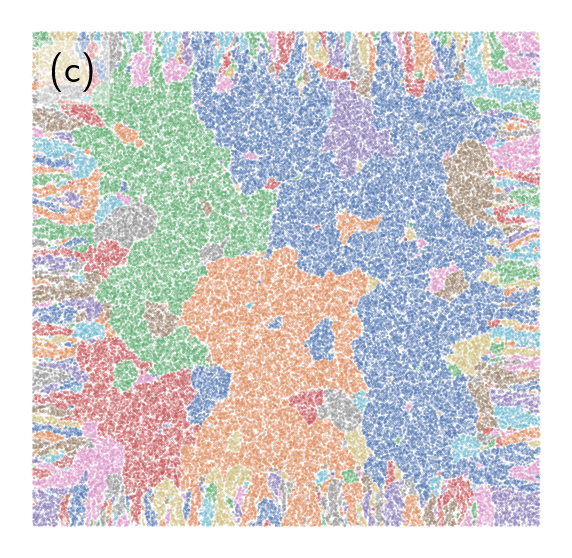

finish


In [39]:
def get_label_dict(g):
    components = g.components(mode='WEAK')
    gcc = components.giant()
    membership = np.array(components.membership)
    number, count = np.unique(membership, return_counts=True)
    number = number[np.argsort(count)[::-1]] 
    label_dict = {i: n for i, n in enumerate(number)}
    reverse_label_dict = {n: i for i, n in enumerate(number)}
    return label_dict, reverse_label_dict, membership
    
def plot_fig4():
    import matplotlib as mpl
    from cycler import cycler
    palette = 'deep'
    #prop_cycle = mpl.rcParams['axes.prop_cycle']
    #mpl.rcParams['axes.prop_cycle'] = cycler(color=sns.color_palette(palette))
    ## Spanning subgraph of the removed nodes
    h, max_pos, _ = load_delta_data(network, size, param, attack, seed)
    th = max_pos + 1

    attack_order = h['attack_order']
    to_delete = set(h.vs['oi']).difference(set(attack_order[:th]))
    h.delete_vertices(to_delete)

    backbone_label_dict, _, backbone_membership = get_label_dict(h)
    backbone_index_dict = {oi: i for i, oi in enumerate(h.vs['oi'])}

    ################

    _colors = [f'C{i}' for i in range(1000)]
    g, _, _ = load_delta_data(network, size, param, attack, seed)    
    position = np.array(g.vs['position'])
    attack_order = g['attack_order']
    to_delete = set(g.vs['oi']).difference(set(attack_order[th:]))
    g.delete_vertices(to_delete)

    label_dict, reverse_label_dict, membership = get_label_dict(g)
    index_dict = {oi: i for i, oi in enumerate(g.vs['oi'])}

    print('start plot')

    def plot_backbone():
        _position = []
        for oi in attack_order[:th]:
            idx = backbone_index_dict[oi]
            if backbone_membership[idx] == backbone_label_dict[0]:
                _position.append(position[oi])
        _position = np.array(_position)
        X, Y = _position[:,0], _position[:,1]
        plt.scatter(X, Y, c='k', marker='*', s=s0, zorder=10)

    def plot_removed():
        _position = []
        for oi in attack_order[:th]:
            idx = backbone_index_dict[oi]
            if backbone_membership[idx] != backbone_label_dict[0]:
                _position.append(position[oi])
        _position = np.array(_position)
        print(_position.shape)
        X, Y = _position[:,0], _position[:,1]
        plt.scatter(X, Y, c='0.4', marker='s', s=s1, zorder=5)

    def plot_components():
        _position = position[attack_order[th:]]
        X, Y = _position[:,0], _position[:,1]
        c_values = []

        for oi in attack_order[th:]:
            idx = index_dict[oi]
            c_values.append('C{}'.format(reverse_label_dict[membership[idx]]%100))
        print('start scatter', flush=True)
        plt.scatter(X, Y, c=c_values, marker='.', s=s2, zorder=0)

    def save_fig():
        base_fig_name = f'breaking_nodes_{network}_L{L}_{attack}_{seed:05d}_th{th}_{palette}_' + to_plot
        fig_name = os.path.join(fig_dir, base_fig_name)
        dpi = 100
        plt.savefig(fig_name + '.png', transparent=False, dpi=dpi)
        plt.savefig(fig_name + '.pdf', dpi=dpi)

    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_facecolor('white')
    sns.despine(bottom=True, left=True)
    if to_plot in ['all', 'removed', 'backbone']:
        print('Plot backbone')
        plot_backbone()
    if to_plot in ['all', 'removed']:
        print('Plot removed')
        plot_removed()
    if to_plot in ['all', 'comps']:
        print('Plot components')
        plot_components()
    
    bbox = dict(
        boxstyle="square",
        ec='white',
        fc='white',
        alpha=0.4
    )
    ax.text(
        0.12, 0.88, f'({letters[panel]})', 
        fontsize=40, transform=ax.transAxes, weight='bold',
        bbox=bbox, va='center', ha='center'
    )
    
    save_fig()
    plt.show()
    
    #mpl.rcParams['axes.prop_cycle'] = prop_cycle
    print('finish')
    
L = 512
size = L*L
attack = 'Btw_cutoff64'
network = 'DT'
seed = 0
to_plot = 'comps'

panel = {
    'Btw': 0,
    'Btw_cutoff128': 1,
    'Btw_cutoff64': 2
}.get(attack, 0)

MarkerSizes = namedtuple('MarkerSizes', ['backbone', 'removed', 'components'])
marker_sizes = {
    32: MarkerSizes(80, 25, 40),
    64: MarkerSizes(30, 20, 15),
    128: MarkerSizes(20, 9, 6),
    256: MarkerSizes(5, 3, 1),
    512: MarkerSizes(2, 1, 0.1)
}
s0 = marker_sizes[L].backbone
s1 = marker_sizes[L].removed
s2 = marker_sizes[L].components

letters = 'abc'
plot_fig4()

# Figure 5

In [32]:
def get_all_comp_sizes():
    all_comp_sizes = {}
    nseeds_values = {}
    
    attacks = [
        'Ran',
        'Deg',
        'Btw',
        'Btw_cutoff2', 
        #'Btw_cutoff3', 
        'Btw_cutoff4',
        'Btw_cutoff8',
        'Btw_cutoff16',
        #'Btw_cutoff31'
        'Btw_cutoff50',
        'Btw_cutoff80',
        'Btw_cutoff110'
    ]
    N = 65536
    ndrop = 1

    f_values_dict = { 
        'Ran': {
            4096: ['-', '0.51270', '-'],
            65536: ['-', '0.50371', '0.50591'],
            131072: ['-', '0.50371', '0.50433', '0.50000'],
        },
        'Deg': {
            65536: ['-', '-', '0.30292', '-']
        },
        'Btw': {
            65536: ['0.06786', '0.07231', '0.07579'],
        },
        'Btw_cutoff2': {
            4096: ['-', '0.29248', '-'],
            65536: ['-', '0.29681', '0.29756'],
            131072: ['-', '0.29683', '-'],
        },
        'Btw_cutoff3': {
            4096: ['-', '0.51270', '-'],
            131072: ['-', '0.27724', '-'],
        },
        'Btw_cutoff4': {
            4096: ['-', '0.25781', '-'],
            65536: ['-', '0.26225', '0.26430'],
            131072: ['-', '0.26305', '-'],
        },
        'Btw_cutoff8': {
            4096: ['-', '0.21582', '-'],
            65536: ['-', '0.22476', '0.22693'],
        },
        'Btw_cutoff16': {
            4096: ['-', '0.17090', '-'],
            65536: ['-', '0.19931', '0.20096', '-'],
        },
        'Btw_cutoff31': {
            4096: ['-', '0.11865', '-'],
        },
        'Btw_cutoff50': {
            65536: ['-', '-', '0.15413', '-']
        },
        'Btw_cutoff80': {
            65536: ['-', '-', '0.10609', '-']
        },
        'Btw_cutoff110': {
            65536: ['-', '-', '0.07664', '-']
        }
    }

    for attack in attacks:
        print(attack)
        f_value = f_values_dict[attack][N][2]
        net_dir_name = NETWORKS_DIR / 'DT' / f'DT_{param}'
        base_net_name = f'DT_param_N{N}'
        base_net_dir_name = net_dir_name / base_net_name
        base_file_name =  f'comp_sizes_{attack}_f{f_value}_drop{ndrop}'
        comp_sizes_file = base_net_dir_name / (base_file_name + '.txt')
        seeds_file = base_net_dir_name / (base_file_name + '_seeds.txt')
        try:
            comp_sizes = np.loadtxt(comp_sizes_file, dtype=int)
        except:
            logger.warning(attack, f_value)
            continue
        try:
            nseeds = len(np.loadtxt(seeds_file, dtype=int))
        except:
            nseeds = 1
        nseeds_values[attack] = nseeds
        all_comp_sizes[attack] = comp_sizes

    print(nseeds_values)
    return all_comp_sizes

all_comp_sizes = get_all_comp_sizes()

Ran
Deg
Btw
Btw_cutoff2
Btw_cutoff4
Btw_cutoff8
Btw_cutoff16
Btw_cutoff50
Btw_cutoff80
Btw_cutoff110
{'Ran': 10000, 'Deg': 10000, 'Btw': 1000, 'Btw_cutoff2': 1000, 'Btw_cutoff4': 100, 'Btw_cutoff8': 100, 'Btw_cutoff16': 100, 'Btw_cutoff50': 100, 'Btw_cutoff80': 100, 'Btw_cutoff110': 100}


[2, 4, 8, 16, 50, 80, 110]


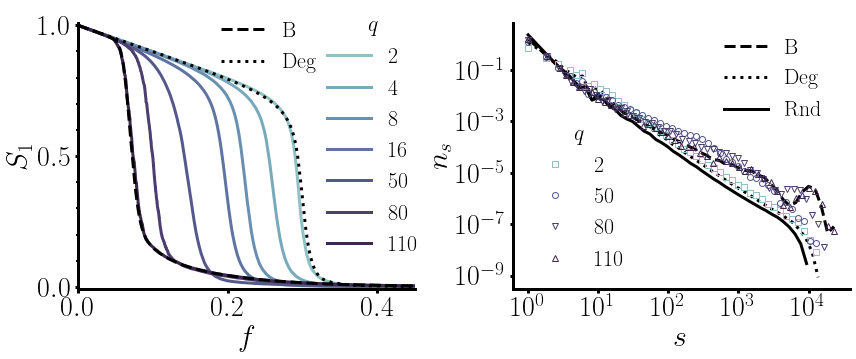

In [33]:
def plot_fig5a(ax):
    net_type = 'DT'
    param = 'param'
    #size = 16384
    size = 65536
    #size = 262144
    min_nseeds = 10
    l_values = [
        2, 4, 8, 16, 50, 80, 110
    ]

    dfs = {}
    for l in l_values:
        attack = f'Btw_cutoff{l}'
        try:
            df = load_dataframe(net_type, size, param, attack, min_nseeds=min_nseeds)
            dfs[l] = df
        except FileNotFoundError:
            print(l)
    l_values = list(sorted(dfs.keys()))
    print(l_values)

    colormap = sns.cubehelix_palette(
        len(l_values), 
        start=0.5, 
        rot=-0.5, 
        light=0.7, dark=0.2
    )
    color_dict = {f'Btw_cutoff{l}': colormap[i] for i, l in enumerate(l_values)}
    base_df = load_dataframe(net_type, size, param, 'Btw', min_nseeds=min_nseeds)
    deg_df = load_dataframe(net_type, size, param, 'Deg', min_nseeds=min_nseeds)

    ax.set_xlabel(r'$f$')
    ax.set_xlim(0, 0.45)   
    ax.set_ylim(-0.01, 1.01)
    ax.set_ylabel(r'$S_1$')
    ax.plot(deg_df.f, deg_df.Sgcc, ':k', label=attack_dict['Deg'], zorder=100)
    for i, l in enumerate(l_values):
        df = dfs[l]
        attack = f'Btw_cutoff{l}'
        ax.plot(df.f, df.Sgcc, color=colormap[i], label=r'${{{}}}$'.format(l))
    ax.plot(base_df.f, base_df.Sgcc, '--', color='k', label=attack_dict['Btw'], zorder=100)
    ax.legend(
        frameon=False, fontsize=20, 
        #loc=(0.0, 0.1)
    )

    handles, labels = ax.get_legend_handles_labels()
    ## q-betweenness
    order = range(1, len(l_values)+1)
    legend1 = ax.legend(
        [handles[idx] for idx in order], [labels[idx] for idx in order],
        fontsize=22, frameon=False,
        loc='upper right',
        bbox_to_anchor=(1.07, 1.1),
        #loc=(0.73, 0.2)
        #loc='best'
    )
    legend1.set_title(r'$q$', prop={'size':22})
    ax.add_artist(legend1)
    ## B and D
    order = [len(l_values)+1, 0]
    ax.legend(
        [handles[idx] for idx in order], [labels[idx] for idx in order],
        fontsize=22, frameon=False, 
        loc=(0.4, 0.78)
    )
    return color_dict

def plot_fig5b(ax, color_dict):    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$s$')
    ax.set_ylabel(r'$n_s$')
    ax.set_xticks([1e0, 1e1, 1e2, 1e3, 1e4])
    ax.set_yticks([1e-1, 1e-3, 1e-5, 1e-7, 1e-9])
    j = 0
    for i, (attack, comp_sizes) in enumerate(all_comp_sizes.items()):
        _attacks = [
            'Btw_cutoff2', 
            #'Btw_cutoff8', 'Btw_cutoff16', 
            'Btw_cutoff50', 
            'Btw_cutoff80', 'Btw_cutoff110', 'Btw', 'Ran', 'Deg'
        ]
        if attack not in _attacks:
            continue
        bins = np.logspace(0, np.log10(comp_sizes.max()+1), 50)
        freq, bin_edges = np.histogram(comp_sizes, bins=bins, density=True)

        X = bin_edges[:-1] 
        Y = freq

        mask = (Y>0)
        X = X[mask]
        Y = Y[mask]

        Y_pred, slope, Y_err = getLinearReg(X[:-1], Y[:-1])
        c = Y_pred[5] / X[5]**slope
        if attack == 'Btw':
            linestyle = '--'
        elif attack == 'Deg':
            linestyle = ':'
        elif attack == 'Ran':
            linestyle = '-'
        else:
            linestyle  = f'{markers[j]}'
            j += 1
        if attack in ['Ran', 'Deg', 'Btw']:
            label = attack_dict[attack]
        else:
            label = r'${{{}}}$'.format(attack.split('off')[1])
        ax.plot(
            X, Y, linestyle , 
            fillstyle='none', 
            color=color_dict.get(attack, 'k'),
            label=label
        )
    #ax.plot(X, powerlaw(X, -2.055, 0.8), '-', color='gray')
    #legend1 = ax.legend(frameon=False, fontsize=20, loc='lower left')
    #
    #
    
    handles, labels = ax.get_legend_handles_labels()
    ## q-betweenness
    order = range(3, len(handles))
    legend1 = ax.legend(
        [handles[idx] for idx in order], [labels[idx] for idx in order],
        fontsize=22, frameon=False,
        loc='lower left'
    )
    legend1.set_title(r'$q$', prop={'size':22})
    ax.add_artist(legend1)
    ## B and D and Ran
    order = [2, 1, 0]
    ax.legend(
        [handles[idx] for idx in order], [labels[idx] for idx in order],
        fontsize=22, frameon=False, 
        loc=(0.6, 0.6)
    )
    
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
color_dict = plot_fig5a(axes[0])
plot_fig5b(axes[1], color_dict)
sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'Bl_attacks_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

# Figure 6

In [3]:
base_attack = 'Btw'
net_type = 'DT'
param = 'param'
min_nseeds = 1000
nseeds = None
threshold = 0.01
sizes = [
    1024, 2048, 4096, 
    8192, 16384, 32768, 65536, 131072
]

rc_values, rc_values_std = get_rc_values(
    net_type, param, base_attack, sizes, 
    nseeds=nseeds, min_nseeds=min_nseeds
)
l_cutoff = get_l_cutoff(
    net_type, param,  base_attack, sizes, 
    threshold=threshold, rc_values=rc_values, 
    nseeds=nseeds, min_nseeds=min_nseeds
)
l_cutoff

INFO: 07/05/2021 09:35:52 AM NumExpr defaulting to 4 threads.


{1024: 16, 2048: 22, 4096: 31, 8192: 42, 16384: 57, 32768: 78}

In [4]:
lmax = 200
l_values = np.arange(1, lmax+1)
_rc_values = {
    size: np.array([rc_values[size][base_attack]] + [np.nan]*lmax)
    for size in sizes
}

_rc_values_std = {
    size: np.array([rc_values_std[size][base_attack]] + [np.nan]*lmax) 
    for size in sizes
}

for size in sizes:
    for l in l_values:
        attack = f'{base_attack}_cutoff{l}'
        if attack in rc_values[size]:
            _rc_values[size][l] = rc_values[size][attack]
            _rc_values_std[size][l] = rc_values_std[size][attack]

In [5]:
l_cutoff[65536] = 110
l_cutoff[131072] = 230

<ipython-input-6-dd1b9a8f3dac>:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


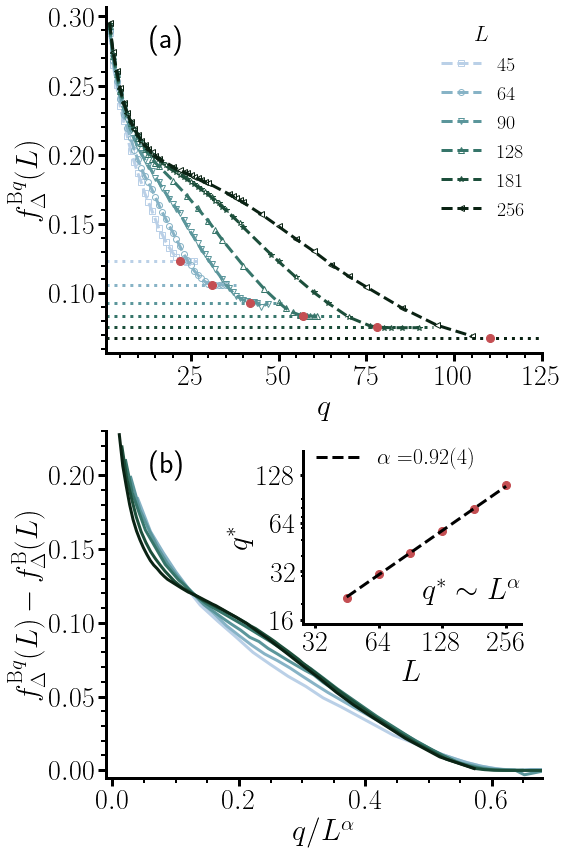

In [6]:
def plot_inset(X, Y, ax):
    bbox_to_anchor = (.48, .48, .5, .5)
    axins = inset_axes(ax, width="100%", height="100%",
            bbox_to_anchor=bbox_to_anchor,
            bbox_transform=ax.transAxes)

    axins.set_xscale('log')
    axins.set_yscale('log')
    axins.plot(X, Y, 'o', color='C3', markersize=8)

    Y_pred, slope, y_err = getLinearReg(X, Y)

    c = Y_pred[-1] / X[-1]**slope
    Y_pred = powerlaw(X, slope, c)

    label = r'$\alpha = $' + r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
    axins.plot(X, Y_pred, '--', color='k', label=label)
    axins.text(0.55, 0.15, r'$q^* \sim L^{\alpha}$', fontsize=30, transform=axins.transAxes)

    _c = Y_pred[-3] / X[-3]
    _Y_pred = powerlaw(X, 1, _c)

    axins.set_xlim(28, 300)
    axins.set_xticks([32, 64, 128, 256])
    axins.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    axins.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

    axins.set_ylim(15, 180)
    axins.set_yticks([16, 32, 64, 128])
    axins.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    axins.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    
    axins.legend(loc=(0.02, 0.84), frameon=False, fontsize=22)

    axins.set_xlabel(r'$L$', fontsize=30)
    axins.set_ylabel(r'$q^*$', fontsize=30)
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    
def fig_6a(rc_values, rc_values_std, ax):
    ax.text(0.1, 0.88, '(a)', transform=ax.transAxes, fontsize=30, weight='bold')
    xlim = 1, 125
    #xlim = 1, 40
    ax.set_xlim(xlim)
    ax.set_xlabel(r'$q$')
    ax.set_ylabel(r'$f^{\mathrm{B}q}_{\Delta}(L)$')

    sizes = list(rc_values.keys())

    colormap = sns.cubehelix_palette(
        len(sizes), start=2, rot=0.3, light=0.8, dark=0.1
    )

    for i, size in enumerate(sizes): 
        L = np.sqrt(size)
        mask = ~np.isnan(rc_values[size][1:])

        X = l_values[mask]
        Y = rc_values[size][1:][mask]
        Y_std = rc_values_std[size][1:][mask]

        try:
            l_cutoff_idx = np.where(X == l_cutoff[size])[0][0] + 5
        except:
            l_cuotff_idx = -1

        X, Y, Y_std = X[:l_cutoff_idx], Y[:l_cutoff_idx], Y_std[:l_cutoff_idx] 

        if True:
            label = r'${{{}}}$'.format(int(np.sqrt(size)))
        else:
            label = ''
        ax.plot(X, Y, '--' + markers[i], 
                color=colormap[i],
                fillstyle='none',
                label=label
        )
        if size in l_cutoff:
            ax.axhline(
                rc_values[size][0], 0, 1.2*l_cutoff[size]/xlim[1],
                linestyle=':', color=colormap[i]
            )
        else:
            ax.axhline(
                rc_values[size][0], linestyle=':', color=colormap[i]
            )
        ax.plot(
            l_cutoff[size], rc_values[size][0], 
            'o', markersize=8, color='C3', zorder=100
        )
        #q = int(0.105*L)
        #ax.plot(q, rc_values[size][q-1], '*', color='C1', markersize=10, zorder=100)
    legend = ax.legend(loc='best', fontsize=20, frameon=False)
    legend.set_title(r'$L$', prop={'size':22})
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    return colormap

def fig_6b(rc_values, rc_values_std, ax, alpha, colormap, fc_values=None):
    ax.text(0.1, 0.88, '(b)', transform=ax.transAxes, fontsize=30, weight='bold')

    sizes = list(rc_values.keys())

    ## Standard
    X = np.sqrt(sizes)
    Y = np.array([l_cutoff[size] for size in sizes])

    plot_inset(X, Y, ax)

    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

    ax.set_xlabel(r'$q/L^{\alpha}$')
    ax.set_ylabel(r'$f^{\mathrm{B}q}_{\Delta}(L)-f^{\mathrm{B}}_{\Delta}(L)$')
    if alpha >= 1:
        xlim = -0.01, 0.5
    else:
        xlim = -0.01, 0.68
        
    ax.set_xlim(xlim)
    ax.set_ylim(-0.005, 0.23)
    #ax.set_xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
    _l_cutoff = {
        k: v for k, v in l_cutoff.items()
    }

    l_cutoff_interp = {}
    for i, size in enumerate(sizes):

        mask = ~np.isnan(rc_values[size][1:])

        L = np.sqrt(size)
        X = l_values[mask]*L**(-alpha)
        Y = rc_values[size][1:][mask] - rc_values[size][0]

        mask = X>0
        X = X[mask]
        Y = Y[mask]
        ax.plot(X, Y, '-', color=colormap[len(colormap)-len(sizes)+i])
    ## Plot mean fc
    if fc_values:
        mean_fc_values = [elem[1] for elem in fc_values]
        ax.plot([0]*len(mean_fc_values), mean_fc_values, 'o')
    
    #ax.axvline(0.1, color='gray')
    
sizes_to_remove = [1024, 131072]
for size in sizes_to_remove:
    if size in _rc_values.keys():
        del _rc_values[size]
        del _rc_values_std[size]
        
ncols = 1
nrows = 2
fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)
colormap = fig_6a(_rc_values, _rc_values_std, axes[0])
alpha = 0.94
fig_6b(_rc_values, _rc_values_std, axes[1], alpha, colormap)
sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'phase_diagram_Bl_{}_alpha{}'.format(net_type, alpha))
plt.savefig(fig_name + '.png', transparent=False)
plt.savefig(fig_name + '.pdf')
plt.show()

# **Supplementary material**

## Figure S2

In [ ]:
measures = ['varSgcc']
attack = 'Btw'

sizes = [
    #1024, 2048,
    #4096, 
    #8192, 
    16384, 
    32768, 65536, 131072,
    262144
]
data = {}

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
N_values = np.array(list(dfs.keys()))
L_values = np.sqrt(N_values)

measure_values = get_critical_measures(dfs, measure, fc='peak')
Y_pred, slope, y_err = getLinearReg(L_values[-5:], measure_values[-5:])
gamma_over_nu = slope
delta_gamma = y_err    
data[measure] = [L_values, measure_values, Y_pred, slope, y_err]

colormap = sns.cubehelix_palette(
    len(L_values), start=2, rot=0.3, light=0.8, dark=0.1
)
ncols = 3
nrows = 1
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.text(0.88, 0.85, '(a)', transform=ax.transAxes, fontsize=30, weight='bold')
ax.set_xlim(0, 0.21)
ax.set_xticks([0.0, 0.05, 0.1, 0.15, 0.2])
ax.set_ylabel(r'$\chi$')
ax.set_xlabel(r'$f$')
ax = axes[1]
ax.set_ylabel(r'$\chi L^{-\gamma/\nu}$')
ax.set_xlabel(r'$(f-f_c) L^{1/\nu}$')  
ax.set_xlim(0, 2)
ax.text(0.88, 0.85, '(b)', transform=ax.transAxes, fontsize=30, weight='bold')
ax.text(0.05, 0.9, r'$f_c = {{{:.3f}}}$'.format(fc), transform=ax.transAxes, fontsize=22)
ax.text(0.05, 0.8, r'$1/\nu = {{{:.2f}}}$'.format(one_over_nu), transform=ax.transAxes, fontsize=22)
ax.text(0.05, 0.7, r'$\gamma/\nu = {{{:.2f}}}$'.format(gamma_over_nu), transform=ax.transAxes, fontsize=22)

ax = axes[0]
for i, N in enumerate(N_values):
    df = dfs[N]
    L = np.sqrt(N)
    ax.plot(
        df.f, df.varSgcc, linestyle='', marker=markers[i], markersize=3, 
        color=colormap[i], label=r'${{{}}}$'.format(N)
    )
      
one_over_nu = 0.58
gamma_over_nu = 2.0
beta_over_nu = 0
fc = 0.03
    
ax = axes[1]
for i, N in enumerate(N_values):
    df = dfs[N]
    L = np.sqrt(N)
    ax.plot(
        (df.f-fc)*L**one_over_nu, df.varSgcc*L**(-gamma_over_nu), linestyle='', 
        marker=markers[i], markersize=3, color=colormap[i]
    )        

legend = axes[0].legend(loc=(0.4, 0.2), fontsize=22, frameon=False)
legend.set_title(r'$L^2$', prop={'size':22})

## Inset
measure = 'varSgcc'
ax = axes[2]
ax.text(0.05, 0.85, '(c)', transform=ax.transAxes, fontsize=30, weight='bold')
ax.set_ylim(5e2, 2e4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(100, 600)
ax.set_xticks([128, 256, 512])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$L$', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_ylabel(r'$\mathrm{Peak\;values}$', fontsize=22)
ax.set_ylabel(r'$\mathrm{Peak\;value}$', fontsize=22)
L_values, measure_values, Y_pred, slope, y_err = data[measure]
markers1, = ax.plot(L_values, measure_values, 'o', markersize=8)
c = measure_values[-3] / L_values[-3]**slope
label = r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
ax.plot(L_values, powerlaw(L_values, slope, c), '--', color='k')
ax.plot([0.45, 0.6], [0.35, 0.35], '-', color='k', transform=ax.transAxes)
ax.plot([0.6, 0.6], [0.35, 0.5], '-', color='k', transform=ax.transAxes)
ax.text(0.45, 0.20, label, transform=ax.transAxes, fontsize=22)

for ax in axes.flatten():
    ax.tick_params(which='major', width=2, length=8)
    ax.tick_params(which='minor', width=1, length=4)
    
sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'collapse_B_twoCols_chi_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

# Figure S3

In [2]:
measures = ['num', 'Nsec']
attacks = [
    'Ran', 
    'Deg', 
    'Btw_cutoff2', 
    'Btw_cutoff3', 'Btw_cutoff4', 
    #'Btw_cutoff5', 'Btw_cutoff6', 'Btw_cutoff7', 
    'Btw_cutoff8', 'Btw_cutoff16'
]

sizes = [
    4096, 8192, 16384, 32768, 65536, 131072, 262144
]

print('attack\t          beta/nu     beta gamma/nu    gamma        2  delta_2      tau delta_tau     N_max')

data = {}
for k, attack in enumerate(attacks):
    #print(attack)
    data[attack] = {}
    
    dfs = {}
    for N in sizes:
        try:
            dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
        except FileNotFoundError:
            continue
    N_values = np.array(list(dfs.keys()))
    L_values = np.sqrt(N_values)
    for i, measure in enumerate(measures):

        try:
            measure_values = get_critical_measures(
                dfs, measure, 
                fc='peak'
                #fc=0.5
                #fc=0.30324
            )
        except:
            print(attack, measure, sizes)
            continue
            
        Y_pred, slope, y_err = getLinearReg(L_values[-5:], measure_values[-5:])
        c = measure_values[-3] / L_values[-3]**slope
        
        nu = 4/3
        if measure in ['Sgcc', 'Nsec']:
            beta_over_nu = 2 - slope
            delta_beta_over_nu = y_err
            beta = beta_over_nu * nu
            delta_beta = delta_beta_over_nu * nu
        elif measure in ['varSgcc', 'num']:
            gamma_over_nu = slope
            delta_gamma_over_nu = y_err
            gamma = gamma_over_nu * nu
            delta_gamma = delta_gamma_over_nu * nu
        data[attack][measure] = [L_values, measure_values, Y_pred, slope, y_err, c]
            
    err_one = np.sqrt((2*delta_beta_over_nu)**2 + delta_gamma**2)
    tau = 2 + beta/(beta+gamma)
    delta_tau = np.fabs(delta_beta)/beta_over_nu +\
               (np.fabs(delta_gamma)+np.fabs(delta_beta))*(beta_over_nu/(beta_over_nu + gamma_over_nu))
    
    nu = 4/3
    if True:
        print(
            '{:10}\t{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:10.4f}{:10.0f}'.format(
                attack, beta_over_nu, beta, gamma_over_nu, gamma,
                2*beta_over_nu+gamma_over_nu, err_one, tau, delta_tau, np.max(N_values)
            )
        )

attack	          beta/nu     beta gamma/nu    gamma        2  delta_2      tau delta_tau     N_max


INFO: 07/08/2021 10:19:18 AM NumExpr defaulting to 4 threads.


Ran       	   0.1055   0.1407   1.7956   2.3942   2.0067   0.0224   2.0555    0.1301    262144
Deg       	   0.1445   0.1926   1.7287   2.3049   2.0176   0.0268   2.0771    0.1125    262144
Btw_cutoff2	   0.1437   0.1916   1.7224   2.2966   2.0099   0.0326   2.0770    0.1028    262144
Btw_cutoff3	   0.1379   0.1839   1.7313   2.3083   2.0071   0.0649   2.0738    0.2429    262144
Btw_cutoff4	   0.1540   0.2054   1.7063   2.2750   2.0143   0.0336   2.0828    0.0535    131072
Btw_cutoff8	   0.1223   0.1630   1.7529   2.3371   1.9974   0.0761   2.0652    0.2287    262144


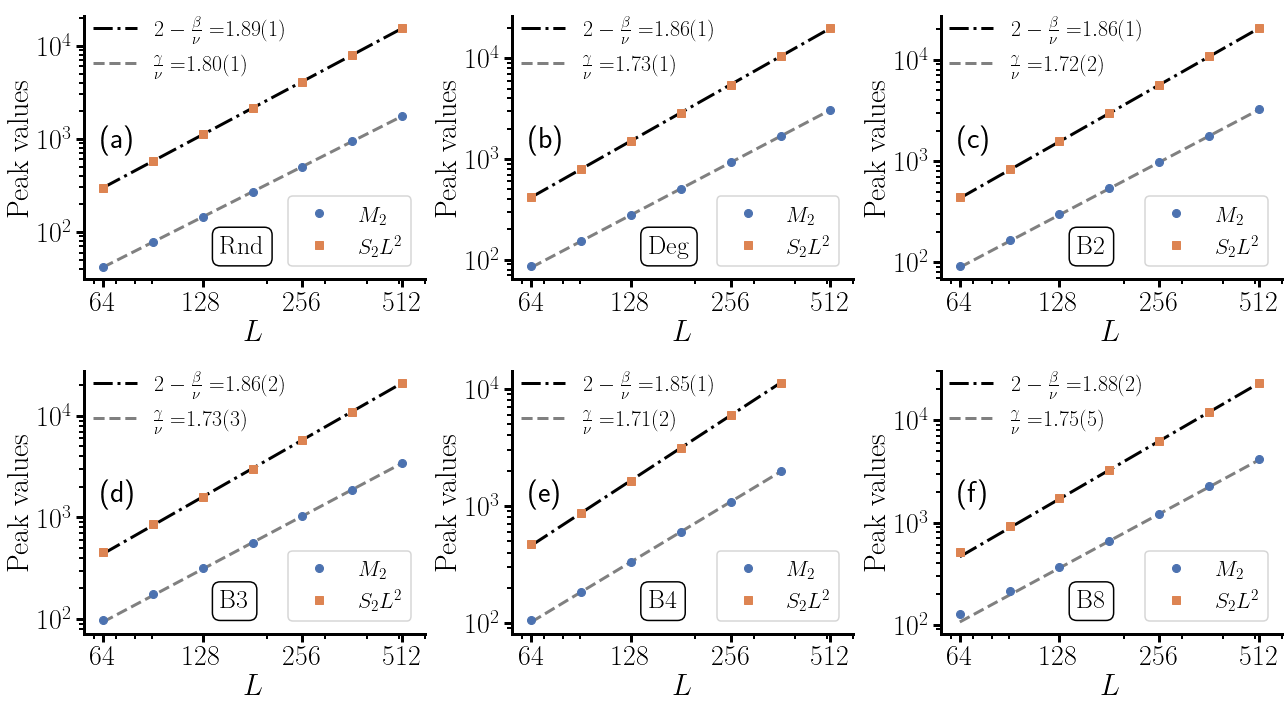

In [5]:
measures = ['num', 'Nsec']

ncols = 3
nrows = len(attacks) // ncols + bool(len(attacks) % ncols)
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
axes = axes.flatten()
for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(56, 600)
    ax.set_xticks([64, 128, 256, 512])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
_letters = 'abcdefghijk'
for k, attack in enumerate(attacks):
    ax = axes[k]

    ax.text(0.05, 0.5, f'({_letters[k]})', transform=ax.transAxes, fontsize=30, weight='bold')
    bbox = {'boxstyle': 'round', 'fc': 'None'}
    ax.text(0.4, 0.1, attack_dict[attack], transform=ax.transAxes, fontsize=26, bbox=bbox)
    ax.set_ylabel(r'$\mathrm{Peak\;values}$')

    for i, measure in enumerate(measures):

        try:
            L_values, measure_values, Y_pred, slope, y_err, c = data[attack][measure]    
        except Exception:
            continue

        if measure in ['num', 'meanS', 'varSgcc']:
            label = r'$\frac{\gamma}{\nu} = $' + r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
            label1 = label
            line1, = ax.plot(L_values, powerlaw(L_values, slope, c), '--', color='grey', label=label)
        elif measure == 'Nsec':
            label = r'$2 - \frac{\beta}{\nu} = $' + r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
            label2 = label
            line2, = ax.plot(L_values, powerlaw(L_values, slope, c), '-.', color='k', label=label)
        else:
            pass

        markers1, = ax.plot(
            L_values, measure_values, marker_dict[measure], 
            color=color_dict[measure], markersize=8, 
            label=measures_dict[measure]
        )

    handles, labels = ax.get_legend_handles_labels()
    ## Markers
    order = [1, 3]
    legend1 = ax.legend(
        [handles[idx] for idx in order], [labels[idx] for idx in order],
        fontsize=22, loc=(0.6, 0.05)
    )

    ax.add_artist(legend1)
    ## Lines
    order = [2, 0]
    ax.legend(
        [handles[idx] for idx in order], [labels[idx] for idx in order],
        fontsize=22, loc=(0.0, 0.73), frameon=False
    )

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'beta_gamma_nu_scaling_Bl_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

# Figure S4

In [14]:
Params = namedtuple('Param', ['fmin', 'fmax', 'ymin', 'ymax'])

attack_params = {
    'Ran': Params(0.4985, 0.5015, 3.7, 5.6),
    'Deg': Params(0.3025, 0.304, 2.7, 3.4),
    'DegU': Params(0.37, 0.385, 2, 8),
    'Btw_cutoff2': Params(0.297, 0.30, 2.5, 3.6),
    'Btw_cutoff3': Params(0.276, 0.283, 2.5, 3.6),
    'Btw_cutoff4': Params(0.263, 0.268, 2.5, 3.8),
    'Btw_cutoff5': Params(0.23, 0.28, 1, 8),
    'Btw_cutoff6': Params(0.22, 0.26, 1, 8),
    'Btw_cutoff7': Params(0.22, 0.26, 1, 8),
    'Btw_cutoff8': Params(0.217, 0.226, 3, 8.5),
    'Btw_cutoff9': Params(0.20, 0.24, 1, 8),
    'Btw_cutoff10': Params(0.18, 0.24, 1, 8),
    'Btw_cutoff11': Params(0.17, 0.24, 1, 8),
    'Btw_cutoff16': Params(0.184, 0.195, 2, 24),
    'Btw_cutoff32': Params(0.15, 0.21, 1, 8),
}
for l in range(12, 16):
    attack_params[f'Btw_cutoff{l}'] = Params(0.17, 0.24, 1, 8)

In [15]:
def load_dataframes(net_type, sizes, param, attack, min_nseeds=100):
    dfs = {}
    for N in sizes:
        try:
            dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=min_nseeds)
        except FileNotFoundError:
            continue
    return dfs
    
def get_fc_values(attacks, sizes, min_nseeds=100):
    fc_values = {}
    for attack in attacks:
        fmin, fmax, ymin, ymax = attack_params[attack]
        _min_nseeds = 1000 if attack == 'Btw_cutoff32' else min_nseeds
        dfs = load_dataframes(net_type, sizes, param, attack, min_nseeds=_min_nseeds)
        dfs = {N: dfs[N] for N in list(dfs.keys())[-3:]}
        mean_fc, std_fc = compute_fc_v2(dfs, fmin, fmax, only_next=True, verbose=False, method='beta')
        fc_values[attack] = (mean_fc, std_fc)    
    return fc_values
    
net_type = 'DT'
min_nseeds = 10000
sizes = [
    #8192, 16384, 
    #32768, 
    65536, 131072, 262144
]

attacks = ['Ran', 'Deg'] + ['Btw_cutoff%d' % l for l in [2, 3, 4, 8, 16]]
fc_values = get_fc_values(attacks, sizes, min_nseeds=min_nseeds)

for attack, fc_value in fc_values.items():
    mean_fc, std_fc = fc_value
    print('{:20}{:.5f} +- {:.5f}{:10f}'.format(attack, mean_fc, std_fc, std_fc/mean_fc))

Ran                 0.50023 +- 0.00015  0.000306
Deg                 0.30327 +- 0.00000  0.000012
Btw_cutoff2         0.29849 +- 0.00050  0.001678
Btw_cutoff3         0.27862 +- 0.00000  0.000000
Btw_cutoff4         0.26486 +- 0.00000  0.000000
Btw_cutoff8         0.22144 +- 0.00000  0.000017
Btw_cutoff16        0.18854 +- 0.00443  0.023496


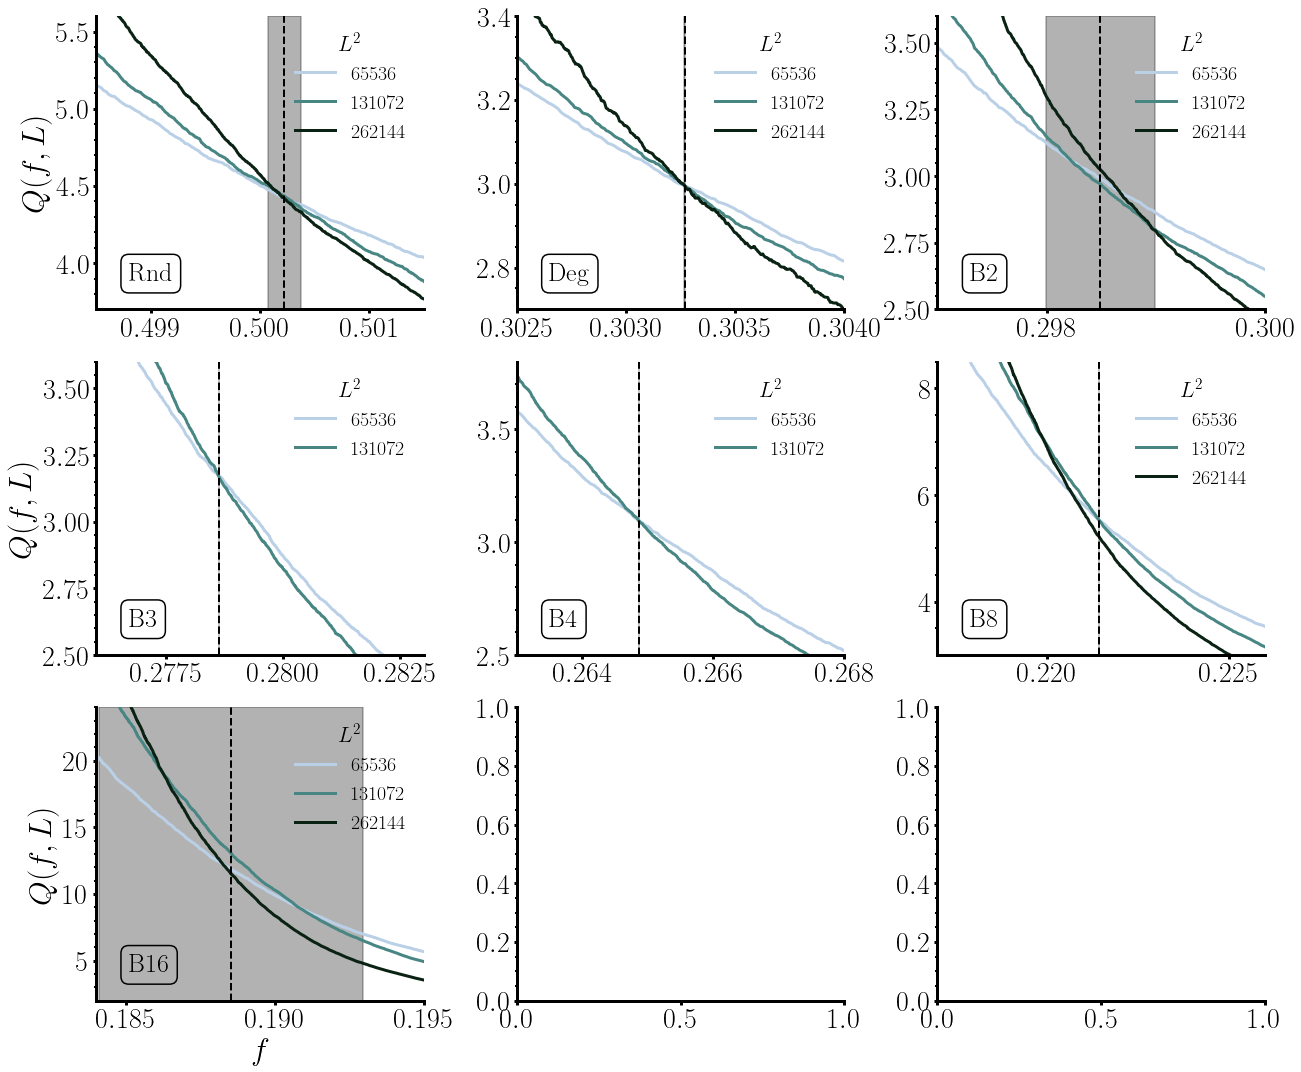

In [16]:
def plot_S1_over_S2(net_type, fc_values, sizes, min_nseeds=100):
    
    colors = sns.cubehelix_palette(len(sizes), start=2, rot=0.3, light=0.8, dark=0.1)

    ncols = 3
    nrows = len(attacks) // ncols 
    if len(attacks) % ncols:
        nrows += 1
    fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    for j, (attack, fc_value) in enumerate(fc_values.items()):        
        mean_fc, std_fc = fc_value
        dfs = load_dataframes(net_type, sizes, param, attack, min_nseeds=min_nseeds)
        #dfs = {N: dfs[N] for N in list(dfs.keys())[-3:]}
        fmin, fmax, ymin, ymax = attack_params[attack]
        ax = axes[j]
        ax.set_xlim(fmin, fmax)
        ax.set_ylim(ymin, ymax)
        if (j % ncols) == 0:
            ax.set_ylabel(r'$Q(f,L)$', fontsize=32)
        if j >= ncols*(nrows-1):
            ax.set_xlabel(r'$f$', fontsize=32)

        for i, N in enumerate(sizes):
            if N not in dfs:
                continue
            df = dfs[N]
            S1_over_S2 = N * df.Sgcc / df.Nsec
            ax.plot(df.f, S1_over_S2, '-', label=r'${{{}}}$'.format(N), color=colors[i])
            
        ax.axvline(mean_fc, linestyle='--', color='k', linewidth=2)
        ax.fill_betweenx([ymin, ymax], mean_fc-std_fc, mean_fc+std_fc, color='k', alpha=0.3)
    
        bbox = {'boxstyle': 'round', 'fc': 'None'}
        ax.text(0.1, 0.1, attack_dict[attack], fontsize=26, transform=ax.transAxes, bbox=bbox, 
                horizontalalignment='left')
        #ax.text(0.04, 0.12, letters[j], fontsize=36, transform=ax.transAxes, 
        #        horizontalalignment='left')
        legend = ax.legend(loc='upper right', fontsize=20, frameon=False)
        legend.set_title(r'$L^2$', prop={'size':22})

    #fig.delaxes(axes[-1])
    sns.despine()
    plt.tight_layout()

    fig_name = os.path.join(fig_dir, 'crossing_method_Bl_' + net_type)
    plt.savefig(fig_name + '.png', transparent=False)
    plt.savefig(fig_name + '.pdf')
    plt.show()
    
plot_S1_over_S2(net_type, fc_values, sizes, min_nseeds=min_nseeds)

-0.23+-0.04


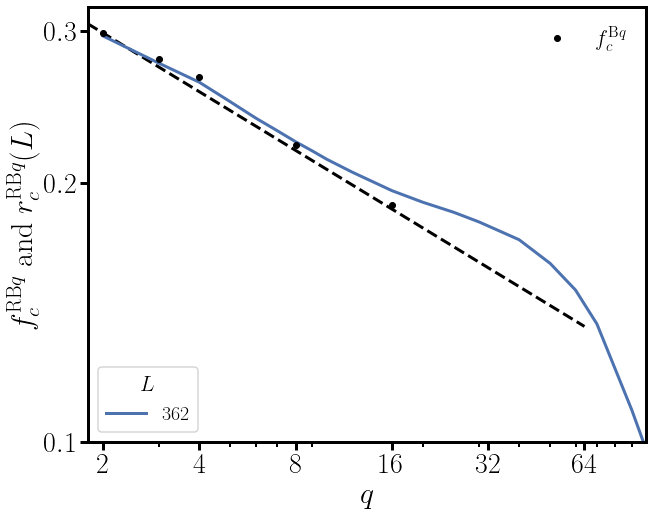

In [11]:
import pickle
l_values = np.arange(2, 200)
rc_values, rc_values_std, l_cutoff = pickle.load(open('../trefemac2021/rc_values.pickle', 'rb'))
l_cutoff[65536] = 110


_l_values = []
mean_fc_values = []
for l in range(2, 17):
    attack = f'Btw_cutoff{l}'
    if attack in fc_values:
        try:
            mean_fc, std_fc = fc_values[attack]
        except:
            continue
        
        _l_values.append(l)
        mean_fc_values.append(mean_fc)
        
ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_ylabel(r'$f_c^{\mathrm{RB}q}\;\mathrm{and}\; r_c^{\mathrm{RB}q}(L)$')
ax.set_xlabel(r'$q$')
ax.set_xscale('log')
ax.set_yscale('log')

X, Y = _l_values, mean_fc_values
#X = X[:7]
#Y = Y[:7]

Y_pred, slope, y_err = getLinearReg(X, Y)
c = Y[0] / X[0]**slope
label = r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
print('{:.2f}+-{:.2f}'.format(slope, y_err))
#label = r'$f_c^{(\mathrm{RB}\ell)} \sim L^{-\omega}$'
ax.plot(X, Y, 'o', label=r'$f_c^{\mathrm{B}q}$', color='k', zorder=100)
#ax.plot(X, Y_pred, '--', color='k', label=label)
x = np.linspace(1, 64)
y = powerlaw(x, slope, c)
ax.plot(x, y, '--', color='k', label=label)


ax.set_xlim(1.8, 100)
ax.set_xticks([2, 4, 8, 16, 32, 64])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_ylim(0.18, 0.32)
ax.set_yticks([0.1, 0.2, 0.3])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())


_sizes = [
    #16384, 
    #32768, 
    #65536, 
    131072
]
for i, size in enumerate(_sizes): 
    if size not in rc_values:
        continue
    L = np.sqrt(size)
    mask = ~np.isnan(rc_values[size][1:])
    
    X = l_values[mask] 

    Y = rc_values[size][1:][mask]
    Y_std = rc_values_std[size][1:][mask]
    
    #ax.plot(l_values, rc_values[size][1:], 'o-', 
    ax.plot(
        X, Y, '-', label=r'${{{}}}$'.format(int(np.sqrt(size)))
    )

handles, labels = ax.get_legend_handles_labels()
## Markers
legend1 = ax.legend(handles[2:], labels[2:],
          fontsize=20, loc='lower left')
legend1.set_title(r'$L$', prop={'size':22})
ax.add_artist(legend1)
## Lines
ax.legend(handles[:1], labels[:1],
          fontsize=22, loc='upper right', frameon=False)

fig_name = os.path.join(fig_dir, 'f_c_and_r_c_Bl{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

In [52]:
deltas = load_delta(net_type, 131072, param, 'Btw_cutoff16')

rc_128 = deltas[:,0].mean()
rc_128

0.1958228286743164

In [57]:
rc_values[65536][15]

0.19734652099609376